In [527]:
# Import data wrangling libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import datetime
import json
import seaborn as sns
sns.set_style(style='ticks')
from scipy import stats

# General DS libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import seaborn as sns
sns.set_style(style='ticks')

# Machine Learning pre-processing libraries
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, StandardScaler

# Machine Learning analysis libraries
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn import tree
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Machine Learning algorithm post-processing libraries
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.cross_validation import train_test_split
from sklearn import model_selection
import sklearn.metrics

# Data Wrangling

In [472]:
# Load and show data dictionary
filename = 'logins.json'
logins = pd.DataFrame(json.load(open(filename)))
logins['login_time'] = pd.to_datetime(logins['login_time'])
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [473]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [474]:
filename = 'ultimate_data_challenge.json'
ult = pd.DataFrame(json.load(open(filename)))
ult['last_trip_date'] = pd.to_datetime(ult['last_trip_date'])
ult['signup_date'] = pd.to_datetime(ult['signup_date'])
ult.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [475]:
ult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


# Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

The overall time series shows strong weekly seasonality and a gradual increasing trend.  

/Users/tsed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


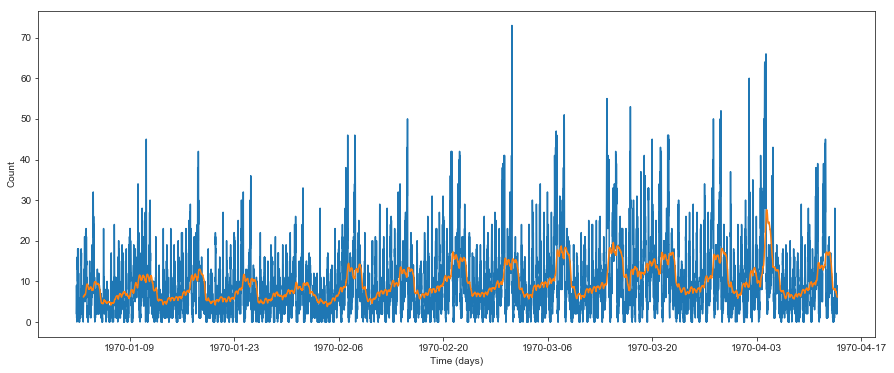

In [476]:
plt.figure(figsize=(15,6))
logins_15 = logins.groupby('login_time',as_index=True)['login_time'].agg({'count':'count'})
logins_15.index = pd.to_datetime(logins_15.index)
logins_15 = logins_15.resample('15T').sum()
rolling_login = logins_15.rolling(window = 90)

plt.plot(logins_15)
plt.plot(r.mean())
plt.xlabel('Time (days)')
plt.ylabel('Count')
plt.show()

A typical weekly cycle shows high demands on the weekends, and lower, but leveled demand on the weekdays.

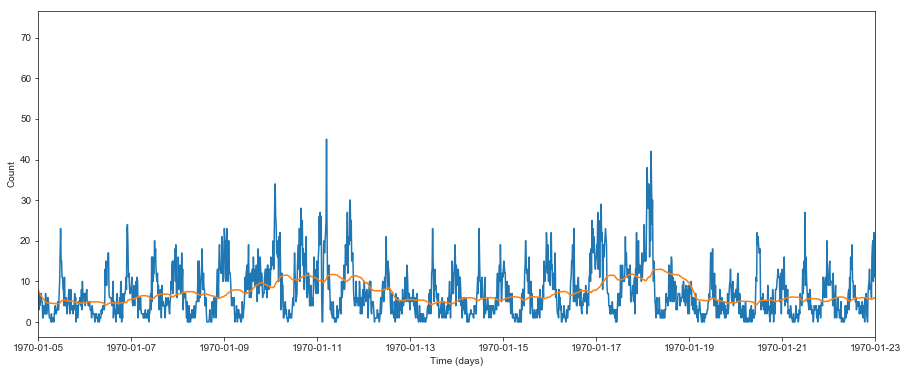

In [477]:
plt.figure(figsize=(15,6))

plt.plot(logins_15)
plt.plot(r.mean())
plt.xlim([datetime.date(1970, 1, 5), datetime.date(1970, 1, 23)])
plt.xlabel('Time (days)')
plt.ylabel('Count')
plt.show()

A typical daily cycle is shown below. Daily cycles show a fairly high, but sporadic demand in the hours after midnight, and a steady increase in demand from noon until 5 PM with a sharp decrease in the early evening. Not many consumers are using the service for morning trips to work, perhaps because both locations are cities likely with mass transportation options.

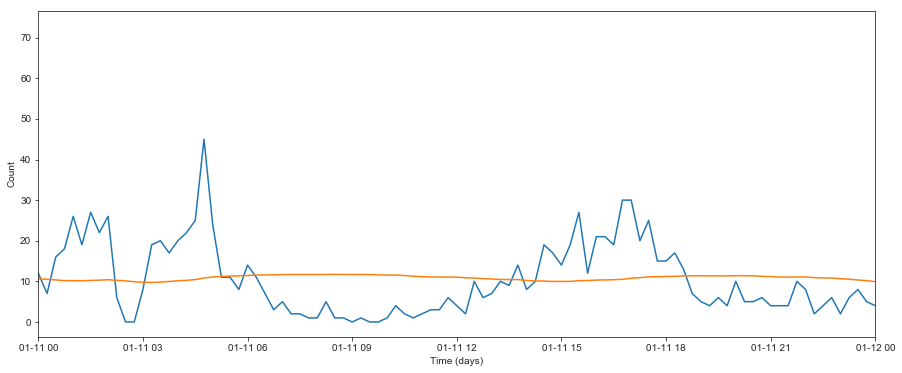

In [478]:
plt.figure(figsize=(15,6))

plt.plot(logins_15)
plt.plot(r.mean())
plt.xlim([datetime.date(1970, 1, 11), datetime.date(1970, 1, 12)])
plt.xlabel('Time (days)')
plt.ylabel('Count')
plt.show()

# Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

**What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**

Given that Gotham is more active at nighttime and Metropolis is more active at daytime, it would be beneficial to fill the valleys of demand. In other words, drivers based in Gotham ideally should be inclined to take trips during the day in Metropolis and then travel back to Gotham for night trips, and vice versa. A key measure of success would be to track profit, i.e. revenue less expenses. If the additional trip revenue generated less the reimbursement costs is greater than zero, the experiment is successful. This is important because increased geographic flexibility would benefit the consumer, but it should not cause a loss for the company in the long-term.

**Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**

**a. how you will implement the experiment**

**b. what statistical test(s) you will conduct to verify the significance of the observation**

**c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.**

A practical experiment would consist of a control and treatment group. Because the demand demonstrates both weekly and daily seasonality, the experiment time duration should be a week. The control group would be drivers who are not reimbursed for tolls, while the treatment group drivers toll expenses are reimbursed. A simple random sample of equal and sufficiently large samples for each group would be performed to ensure the groups are statistically similar and have low sampling error (margin of error).



A two-sample T-test would be used to determine significance of the reimbursement on the the profitability of the drivers. The statistical test could be performed on a daily basis, or in aggregate for the week. The null and alternate hypothesis should be:
- $H_0$: reimbursed drivers $\mu$ = non-reimbursed drivers 
- $H_1$: reimbursed drivers $\mu$ != non-reimbursed drivers 
- $\alpha$ = 0.05



If the profits generated are statistically significant and practically significant (no loss in revenue), then I would recommend that the city operations team reimburse all drivers within Gotham and Metropolis based on days that produced statistically significant profits; weekdays are more likely to show this result. A caveat would be that this test is specific to Gotham and Metropolis and should not be replicated for other cities without additional experimentation.

# Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

**Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?**

- Weekdays showed a moderate positive correlation with average distance, but a weak negative correlation with price surges.
- Driver ratings showed a moderate positive correlation.
- 37.61% of users are considered retained.

Data Dictionary:
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYY MM DD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

In [479]:
# Adjust data types
ult.loc[:,'ultimate_black_user'] = ult.loc[:,'ultimate_black_user'].astype('category')
ult.loc[:,'city'] = ult.loc[:,'city'].astype('category')
ult.loc[:,'phone'] = ult.loc[:,'phone'].astype('category')
ult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null category
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null category
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null category
weekday_pct               50000 non-null float64
dtypes: category(3), datetime64[ns](2), float64(6), int64(1)
memory usage: 3.6 MB


In [480]:
# map city names to prevent string input issues in predictive modeling
ult['city'] = ult['city'].map({"King's Landing" : "kings", 
                               "Astapor" : "astapor", 
                               "Winterfell": 'winterfell'})

In [482]:
# Summary statistics
ult.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


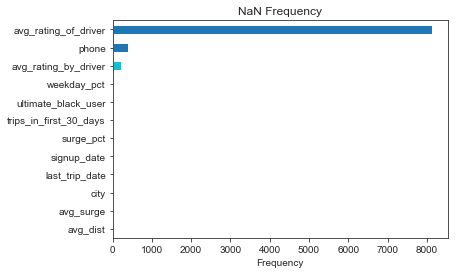

In [483]:
# Check if features have null values
pd.Series(ult.isnull().sum()).sort_values(ascending=True).plot.barh(width=0.5)
plt.title('NaN Frequency')
plt.xlabel('Frequency')
plt.show()

In [484]:
# Impute null continuous variables
ult['avg_rating_of_driver'] = ult['avg_rating_of_driver'].fillna((ult['avg_rating_of_driver'].mean()))
ult['avg_rating_by_driver'] = ult['avg_rating_by_driver'].fillna((ult['avg_rating_by_driver'].mean()))

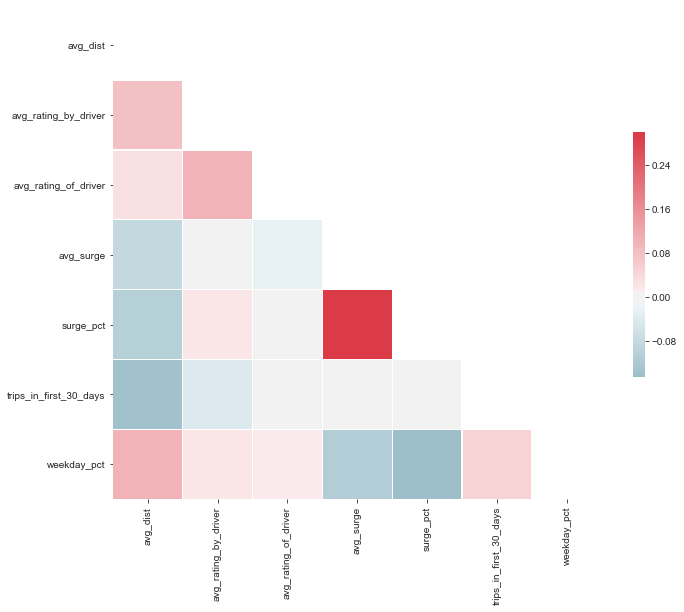

In [485]:
# Compute the correlation matrix
corr = ult.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

/Users/tsed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


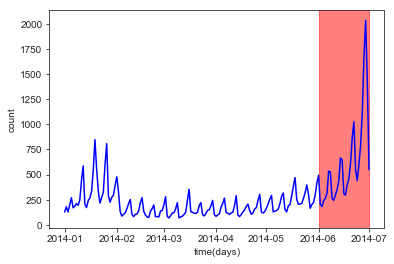

In [529]:
# What fraction of the observed users were retained?
# we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

usage = ult.groupby('last_trip_date',as_index=True)['last_trip_date'].agg({'count':'count'})
plt.plot(usage, color='blue')
plt.axvspan('2014-06', '2014-07', alpha=0.5, color='red')
plt.ylabel('count')
plt.xlabel('time(days)')
plt.show()

In [487]:
ult['retained'] = ult.last_trip_date >= '2014-06-01'
print('Percentage Retained: {:.2f}%'.format(ult.retained.sum()/len(ult.retained)*100))

Percentage Retained: 37.61%


**Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.**

The binary classification problem that may be modeled best with logistic regression because of its interpretability and fairly good performance; a quick evaluation with other machine learning models without additional tuning demonstrated that the out-of-the-box logistic regression model was on par with other models such as: K-Nearest Neighbors, Classification and Regression Trees, Naive Bayes, and Support Vector Machines. The model is valid because because it resulted in fair performance based on an ROC AUC of 76%, which is an improvement over the dummy classifier at 50%. The F-1 score also shows that the logistic regression model is performing well at 71% compared to 54% for the dummy classifier. The class imbalance is not too severe; re-sampling methods would not improve in the result much.

In [488]:
ult.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,kings,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,5.0,5.0,1.00,astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False
2,0.77,5.0,4.3,1.00,astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,False
3,2.36,4.9,4.6,1.14,kings,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True
4,3.13,4.9,4.4,1.19,winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,False


In [489]:
X = pd.get_dummies(ult.loc[:, ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver','avg_surge',
                                'city', 'phone', 'surge_pct', 'trips_in_first_30_days',
                                'ultimate_black_user', 'weekday_pct']], drop_first=True, dummy_na=True)
Y = ult['retained'].values
X.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_kings,city_winterfell,city_nan,phone_iPhone,phone_nan,ultimate_black_user_True,ultimate_black_user_nan
0,3.67,5.0,4.7,1.10,15.4,4,46.2,1,0,0,1,0,1,0
1,8.26,5.0,5.0,1.00,0.0,0,50.0,0,0,0,0,0,0,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,0,0,0,1,0,0,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,1,0,0,1,0,1,0
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0,1,0,0,0,0,0


In [490]:
X_columns = X.columns
# imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
# X = imputer.fit_transform(X)
X = pd.DataFrame(X)
X.columns = X_columns

In [491]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

# Scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


DUMMY: 0.527600 (0.006415)
LR: 0.716107 (0.009789)
KNN: 0.739120 (0.005818)
CART: 0.700800 (0.008697)
NB: 0.713573 (0.009483)
SVM: 0.765973 (0.007474)


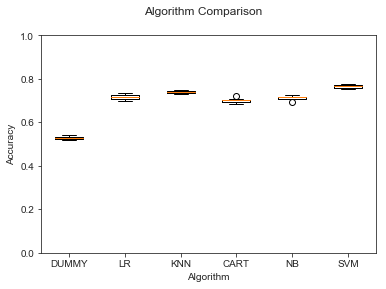

In [418]:
# Load dataset
X_compare = X_train
Y_compare = Y_train

# Prepare configuration for cross validation test harness
seed = 7

# Prepare models
models = []
models.append(('DUMMY', DummyClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_compare, Y_compare, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylim(0, 1)
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.show()

Class 0: 31196
Class 1: 18804


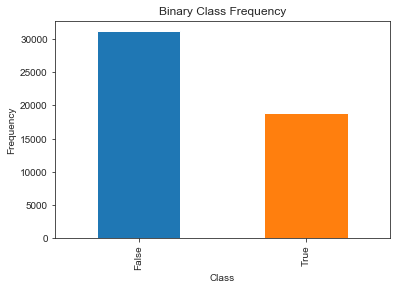

In [492]:
target_count = ult.retained.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
target_count.plot(kind='bar', title='Binary Class Frequency')
plt.ylabel('Frequency')
plt.xlabel('Class')
plt.show()

In [493]:
# K-Fold Cross-Validation
num_folds = 10
seed = 42
kfold = KFold(n_splits=num_folds, random_state=seed)
dc = DummyClassifier()
scoring = ['neg_log_loss', 'accuracy']
for score in scoring:
    results = cross_val_score(dc, X_train, Y_train, cv=kfold, scoring=score)
    print(score,": %.3f (%.3f)" % (results.mean(), results.std()))
dc.fit(X_train, Y_train)
Y_pred = dc.predict(X_test)
report = classification_report(Y_test, Y_pred)
print('Classification Report: \n', classification_report(Y_test, Y_pred), '\n')

neg_log_loss : -16.367 (0.369)
accuracy : 0.529 (0.008)
Classification Report: 
              precision    recall  f1-score   support

      False       0.63      0.63      0.63      7808
       True       0.38      0.38      0.38      4692

avg / total       0.54      0.54      0.54     12500
 



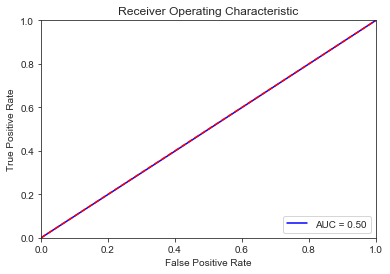

In [494]:
# Visualize the Receiver Operator Curve (ROC)
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR) for all thresholds of the classification
#.90-1 = excellent (A)
#.80-.90 = good (B)
#.70-.80 = fair (C)
#.60-.70 = poor (D)
#.50-.60 = fail (F)
probs = dc.predict_proba(X_test) # returns probability estimates for test set 
preds = probs[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test, preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [495]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# K-Fold Cross-Validation
num_folds = 10
seed = 42
kfold = KFold(n_splits=num_folds, random_state=seed)
lr = LogisticRegression()
lr_grid = GridSearchCV(estimator = lr, param_grid = param_grid, cv = num_folds)
scoring = ['accuracy']
for score in scoring:
    results = cross_val_score(lr_grid, X_train, Y_train, cv=kfold, scoring=score)
    print(score,": %.3f (%.3f)" % (results.mean(), results.std()))

lr_grid.fit(X_train, Y_train)
Y_pred = lr_grid.predict(X_test)
report = classification_report(Y_test, Y_pred)
print('Classification Report: \n', classification_report(Y_test, Y_pred), '\n')

best_parameters = lr_grid.best_params_
print(best_parameters)

accuracy : 0.718 (0.008)
Classification Report: 
              precision    recall  f1-score   support

      False       0.74      0.86      0.79      7808
       True       0.68      0.49      0.57      4692

avg / total       0.72      0.72      0.71     12500
 

{'C': 0.001}


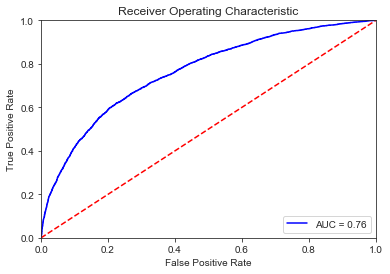

In [496]:
# Visualize the Receiver Operator Curve (ROC)
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR) for all thresholds of the classification
#.90-1 = excellent (A)
#.80-.90 = good (B)
#.70-.80 = fair (C)
#.60-.70 = poor (D)
#.50-.60 = fail (F)
probs = lr_grid.predict_proba(X_test) # returns probability estimates for test set 
preds = probs[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test, preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

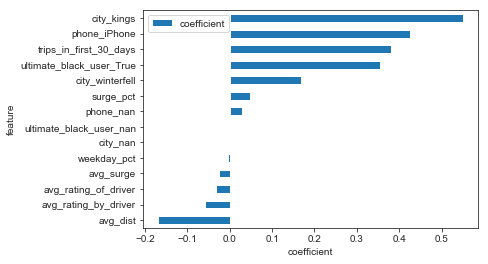

,coefficient
avg_dist,-0.168346
avg_rating_by_driver,-0.059339
avg_rating_of_driver,-0.031890
avg_surge,-0.024530
weekday_pct,-0.004388
city_nan,0.000000
ultimate_black_user_nan,0.000000
phone_nan,0.028901
surge_pct,0.048341
city_winterfell,0.168812


In [497]:
coef = list(lr_grid.best_estimator_.coef_[0])
coef = pd.DataFrame(coef, columns= ['coefficient'])
coef.index = X.columns
coef.sort_values('coefficient').plot(kind='barh')
plt.ylabel('feature')
plt.xlabel('coefficient')
plt.show()
coef.sort_values('coefficient')

In [528]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

X_train = pd.DataFrame(X_train, columns = X.columns)
Y_train = pd.DataFrame(Y_train)
all_columns = '+'.join(X_train.columns)
ult2 = X_train.copy()
ult2['retained'] = Y_train.astype(int)
formula = 'retained ~ ' + all_columns
logit = smf.glm(formula=formula, data=ult2, family=sm.families.Binomial())
result = logit.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               retained   No. Observations:                37500
Model:                            GLM   Df Residuals:                    37487
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20933.
Date:                Sun, 18 Nov 2018   Deviance:                       41865.
Time:                        20:26:53   Pearson chi2:                 4.57e+04
No. Iterations:                     5   Covariance Type:             nonrobust
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.5996      0.012    -49.126      0.000      -0.624      -0.576
avg_dist  

/Users/tsed/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/tsed/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/tsed/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/tsed/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


**Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).**

Ultimate may consider the following actions to improve its longterm rider retention:
- Improve the iphone application user experience
- Offer ultimate black trip discounts for new users
- Target the King's landing consumer base, or study these customers more closely for additional insight
- Encourage users to use the service in their first 30 days through discounts and promotions